<a href="https://colab.research.google.com/github/jaw039/Google-Colab-Notebooks/blob/main/Linear_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math

# Kernels
The implementations are included in the SVM class as it defaults to linear.

```
def kernel_linear(x1, x2):
    """Linear kernel: <x1, x2>"""
    return np.dot(x1, x2)

def kernel_polynomial(x1, x2, degree=3, coef0=1.0, gamma=1.0):
    """Polynomial kernel: (gamma*<x1,x2> + coef0)^degree"""
    return (gamma * np.dot(x1, x2) + coef0) ** degree

def kernel_rbf(x1, x2, gamma=None):
    """Radial Basis Function (Gaussian) kernel"""
    if gamma is None:
        gamma = 1.0 / x1.shape[0]   # default: 1 / number of features
    diff = x1 - x2
    return math.exp(-gamma * np.dot(diff, diff))

def kernel_sigmoid(x1, x2, gamma=1.0, coef0=1.0):
    """Sigmoid kernel: tanh(gamma*<x1,x2> + coef0)"""
    return math.tanh(gamma * np.dot(x1, x2) + coef0)

def get_kernel_matrix(X, kernel, **kargs):
    """Compute the full kernel matrix K_ij = k(x_i, x_j)."""
    n_samples = X.shape[0]
    K = np.empty((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i, n_samples):
            k_val = kernel(X[i], X[j], **kargs)
            K[i, j] = k_val
            K[j, i] = k_val          # symmetry
    return K
```

# Linear SVM Class

In [ ]:
class SVM: # Defaults to linear
    """
    Linear SVM trained by a simplified SMO algorithm on the dual.
    - Works for binary labels y in {-1, +1}
    - Soft margin when C is finite
    - Hard margin approximated with a very large C
    - No kernels (purely linear)

    After fit():
      - self.alpha: Lagrange multipliers (shape [m])
      - self.w, self.b: primal params with w = sum_i alpha_i y_i x_i
      - self.support_indices_: indices with alpha_i > tol
      - self.margin_sv_: indices with 0 < alpha_i < C - tol  (only meaningful if C < inf)
      - self.error_sv_: indices with alpha_i >= C - tol       (only meaningful if C < inf)
    """

    def __init__(self, C=1.0, tol=1e-4, eps=1e-6, max_passes=10, random_state=0):
        """
        C: soft-margin penalty. Use None or "hard" to approximate hard margin.
        tol: KKT tolerance for selecting violators.
        eps: minimal alpha change threshold within an SMO step.
        max_passes: SMO stopping criterion: consecutive passes with no alpha updates.
        """
        if C is None or (isinstance(C, str) and C.lower() == "hard"):
            # Large C approximates hard-margin constraints (requires separable data)
            C = 1e12
        self.C = float(C)
        self.tol = float(tol)
        self.eps = float(eps)
        self.max_passes = int(max_passes)
        self.random_state = int(random_state)

        # Learned params (set in the fit function)
        self.alpha = None
        self.b = 0.0
        self.w = None   # only for linear kernel
        # You will need to implement the following in your code
        self.alphas = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_vector_alphas = None

        # Bookkeeping
        self.support_indices_ = None
        self.margin_sv_ = None
        self.error_sv_ = None

    def _linear_kernel(self, X, Z):
        # Linear kernel K(x, z) = x · z
        return X @ Z.T

    def fit(self, X, y):
        """
        X: (m, n) numpy array
        y: (m,) labels in {-1, +1}
        """
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)
        assert set(np.unique(y)).issubset({-1.0, 1.0}), "y must be in {-1, +1}"

        m, n = X.shape
        rng = np.random.RandomState(self.random_state)

        # Precompute kernel matrix for efficiency (linear)
        K = self._linear_kernel(X, X)

        # Initialize dual variables
        alpha = np.zeros(m, dtype=float)
        b = 0.0

        # Error cache: E_i = f(x_i) - y_i
        def f(i):
            # f(x_i) = sum_j alpha_j y_j K_ji + b
            return float(np.dot(alpha * y, K[:, i]) + b)

        def E(i):
            return f(i) - y[i]

        passes = 0
        while passes < self.max_passes:
            num_changed = 0

            for i in range(m):
                Ei = E(i)
                # KKT violation check (for selection), per standard SMO logic
                # Conditions for optimizing i:
                # (y_i * f_i < 1 - tol and alpha_i < C) or
                # (y_i * f_i > 1 + tol and alpha_i > 0)
                yi_fi = y[i] * f(i)
                if ((yi_fi < 1 - self.tol and alpha[i] < self.C) or
                    (yi_fi > 1 + self.tol and alpha[i] > 0)):

                    # Pick j != i (heuristic: random, you could implement max |Ei - Ej|)
                    j = i
                    while j == i:
                        j = rng.randint(0, m)
                    Ej = E(j)

                    alpha_i_old, alpha_j_old = alpha[i], alpha[j]

                    # Compute L and H (box constraints)
                    if y[i] != y[j]:
                        L = max(0.0, alpha[j] - alpha[i])
                        H = min(self.C, self.C + alpha[j] - alpha[i])
                    else:
                        L = max(0.0, alpha[i] + alpha[j] - self.C)
                        H = min(self.C, alpha[i] + alpha[j])

                    if abs(L - H) < 1e-15:
                        continue

                    # eta = 2 * K_ij - K_ii - K_jj
                    eta = 2.0 * K[i, j] - K[i, i] - K[j, j]
                    if eta >= 0:
                        # Non-positive definiteness in this 2D subproblem; skip
                        continue

                    # Update alpha_j
                    alpha[j] = alpha_j_old - (y[j] * (Ei - Ej)) / eta
                    # Clip
                    if alpha[j] > H:
                        alpha[j] = H
                    elif alpha[j] < L:
                        alpha[j] = L

                    if abs(alpha[j] - alpha_j_old) < self.eps:
                        alpha[j] = alpha_j_old
                        continue

                    # Update alpha_i accordingly
                    alpha[i] = alpha_i_old + y[i] * y[j] * (alpha_j_old - alpha[j])

                    # Compute b1, b2 and update b
                    b1 = (b - Ei
                          - y[i] * (alpha[i] - alpha_i_old) * K[i, i]
                          - y[j] * (alpha[j] - alpha_j_old) * K[i, j])
                    b2 = (b - Ej
                          - y[i] * (alpha[i] - alpha_i_old) * K[i, j]
                          - y[j] * (alpha[j] - alpha_j_old) * K[j, j])

                    # Choose new b (per Platt)
                    if 0 < alpha[i] < self.C:
                        b = b1
                    elif 0 < alpha[j] < self.C:
                        b = b2
                    else:
                        b = 0.5 * (b1 + b2)

                    num_changed += 1

            if num_changed == 0:
                passes += 1
            else:
                passes = 0

        # Store learned parameters
        self.alpha = alpha
        self.b = float(b)
        # Primal weight vector w = sum_i alpha_i y_i x_i
        self.w = (alpha * y) @ X

        # Identify support vectors formally via alpha
        tol = 1e-8
        self.support_indices_ = np.where(alpha > tol)[0]
        if math.isfinite(self.C):
            self.margin_sv_ = np.where((alpha > tol) & (alpha < self.C - tol))[0]
            self.error_sv_ = np.where(alpha >= self.C - tol)[0]
        else:
            # Shouldn't occur because we map "hard" to large finite C above
            self.margin_sv_ = self.support_indices_
            self.error_sv_ = np.array([], dtype=int)

        return self

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        return X @ self.w + self.b

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0.0, 1.0, -1.0)

    def functional_margins(self, X, y):
        """Return y_i * (w·x_i + b); SVs satisfy <= 1 in soft-margin optimum."""
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)
        return y * self.decision_function(X)

    def geometric_margin(self):
        """Return 1/||w|| (distance from hyperplane to margin) if w != 0."""
        norm_w = np.linalg.norm(self.w)
        return 1.0 / norm_w if norm_w > 0 else np.inf

    def get_support_vectors(self):
        """Return the support vectors, their labels and corresponding alphas."""
        return (self.support_vectors,
                self.support_vector_labels,
                self.support_vector_alphas)

    def kernel_linear(x1, x2):
        """Linear kernel: <x1, x2>"""
        return np.dot(x1, x2)

    def kernel_polynomial(x1, x2, degree=3, coef0=1.0, gamma=1.0):
        """Polynomial kernel: (gamma*<x1,x2> + coef0)^degree"""
        return (gamma * np.dot(x1, x2) + coef0) ** degree

    def kernel_rbf(x1, x2, gamma=None):
        """Radial Basis Function (Gaussian) kernel"""
        if gamma is None:
            gamma = 1.0 / x1.shape[0]   # default: 1 / number of features
        diff = x1 - x2
        return math.exp(-gamma * np.dot(diff, diff))

    def kernel_sigmoid(x1, x2, gamma=1.0, coef0=1.0):
        """Sigmoid kernel: tanh(gamma*<x1,x2> + coef0)"""
        return math.tanh(gamma * np.dot(x1, x2) + coef0)

    def get_kernel_matrix(X, kernel, **kargs):
        """Compute the full kernel matrix K_ij = k(x_i, x_j)."""
        n_samples = X.shape[0]
        K = np.empty((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(i, n_samples):
                k_val = kernel(X[i], X[j], **kargs)
                K[i, j] = k_val
                K[j, i] = k_val          # symmetry
        return K

# Test

In [ ]:
# Toy linearly separable set
X = np.array([
    [2, 2], [2, 0], [0, 0], [0, 2],     # class +1-ish cluster
    [3, 3], [3, 1], [1, 3],             # class +1
    [6, 6], [6, 8], [8, 6], [8, 8],     # class -1-ish cluster
    [7, 7], [9, 7], [7, 9]              # class -1
], dtype=float)
y = np.array([1, 1, 1, 1, 1, 1, 1,  -1, -1, -1, -1, -1, -1, -1], dtype=float)



In [ ]:
X.shape

(14, 2)

In [ ]:
X[:,0].reshape(-1,1).shape
import pandas as pd
Xdf = pd.DataFrame(X, columns = ['x1', 'x2'])
Xdf

,x1,x2
0,2.0,2.0
1,2.0,0.0
2,0.0,0.0
3,0.0,2.0
4,3.0,3.0
5,3.0,1.0
6,1.0,3.0
7,6.0,6.0
8,6.0,8.0
9,8.0,6.0


<Axes: xlabel='x1', ylabel='x2'>

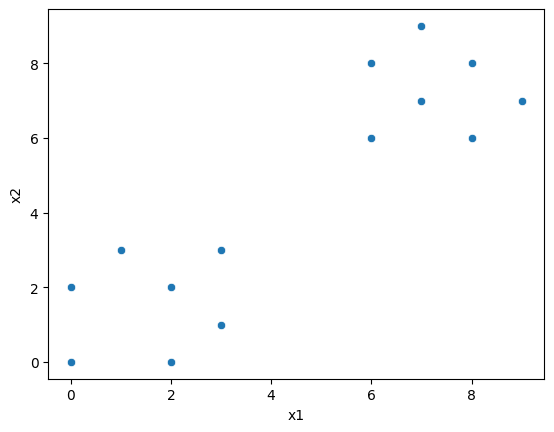

In [ ]:
import seaborn as sns
sns.scatterplot(data = Xdf, x='x1', y='x2')

In [ ]:
# Hard-margin approximation (large C)
svm_hard = SVM(C="hard", max_passes=20, random_state=42).fit(X, y)
print("Hard-margin w, b:", svm_hard.w, svm_hard.b)
print("Support vectors (hard):", svm_hard.support_indices_)

# Soft-margin (finite C)
svm_soft = SVM(C=1.0, max_passes=20, random_state=42).fit(X, y)
print("Soft-margin w, b:", svm_soft.w, svm_soft.b)
print("Support vectors (soft):", svm_soft.support_indices_)
print("Margin SVs (0<alpha<C):", svm_soft.margin_sv_)
print("Error SVs   (alpha≈C): ", svm_soft.error_sv_)

# Predictions
preds = svm_soft.predict(X)
acc = (preds == y).mean()
print("Train accuracy (soft):", acc)

Hard-margin w, b: [-0.33333333 -0.33333333] 3.0
Support vectors (hard): [4 7]
Soft-margin w, b: [-0.33333333 -0.33333333] 3.0
Support vectors (soft): [4 7]
Margin SVs (0<alpha<C): [4 7]
Error SVs   (alpha≈C):  []
Train accuracy (soft): 1.0


# Plotting

In [ ]:
import matplotlib.pyplot as plt

def plot_linear_svm(svm, X, y, title="Linear SVM Decision Boundary"):
    """
    Plot decision boundary, margins, and highlight support vectors.

    Parameters
    ----------
    svm : trained LinearSVM
    X : (m,2) array
    y : (m,) array in {-1, +1}
    """
    assert X.shape[1] == 2, "This plotter works only for 2D data."

    # Plot decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z > 0, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'],
                linestyles=['--', '-', '--'])

    # Plot training points
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b', marker='o', label='Class +1')
    plt.scatter(X[y == -1, 0], X[y == -1, 1], c='r', marker='s', label='Class -1')

    # Highlight support vectors
    sv = svm.support_indices_
    plt.scatter(X[sv, 0], X[sv, 1], s=120, facecolors='none',
                edgecolors='k', linewidths=1.5, label='Support Vectors')

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_svm_decision_boundary(svm, X, y, resolution=200, title='SVM Decision Boundary'):
    """
    Parameters
    ----------
    svm : trained SVM object
    X : ndarray, shape (n_samples, 2)
        Training data (must be 2‑D for the plot).
    y : ndarray, shape (n_samples,)
        Labels (+1 / -1).
    resolution : int
        Number of points along each axis in the mesh grid.
    title : str
        Title for the figure.

    Note: You will need to implement your own support_vectors.
    Currently I have implemented support indices for you

    svm.support_vectors,
    svm.support_vector_labels,
    svm.support_vector_alphas
    """

    # 1. Build a grid that covers the data range
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # 2. Compute decision values for every point in the grid
    #    (vectorised version of svm.predict but returns the raw score)
    def decision_function(grid):
        scores = np.zeros(grid.shape[0])
        for sv, sv_y, sv_a in zip(
            svm.support_vectors,
            svm.support_vector_labels,
            svm.support_vector_alphas
        ):
            k_vals = np.array([svm.kernel(sv, x, **svm.kargs) for x in grid])
            scores += sv_a * sv_y * k_vals
        scores += svm.b
        return scores

    zz = decision_function(grid).reshape(xx.shape)

    # 3. Plotting
    plt.figure(figsize=(8, 6))
    # Decision boundary: contour where f(x)=0
    # Margins: f(x)=±1 (for hard‑margin)
    contour_levels = [-1.0, 0.0, 1.0]
    cs = plt.contour(xx, yy, zz, levels=contour_levels,
                     colors=['gray', 'black', 'gray'],
                     linestyles=['--', '-', '--'],
                     linewidths=[1, 2, 1])
    # Add a legend entry for the margins and boundary
    plt.clabel(cs, inline=1, fontsize=10,
               fmt={-1.0: 'Margin', 0.0: 'Decision boundary', 1.0: 'Margin'})

    # Plot the training points
    plt.scatter(X[y==1, 0], X[y==1, 1], c='b', marker='o',
                label='Class +1', edgecolors='k')
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='r', marker='s',
                label='Class -1', edgecolors='k')

    # Highlight support vectors (larger, unfilled)
    sv = svm.support_vectors
    plt.scatter(sv[:, 0], sv[:, 1], s=200, facecolors='none',
                edgecolors='k', linewidths=1.5,
                label='Support vectors')

    plt.title(title)
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.legend(loc='upper right')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

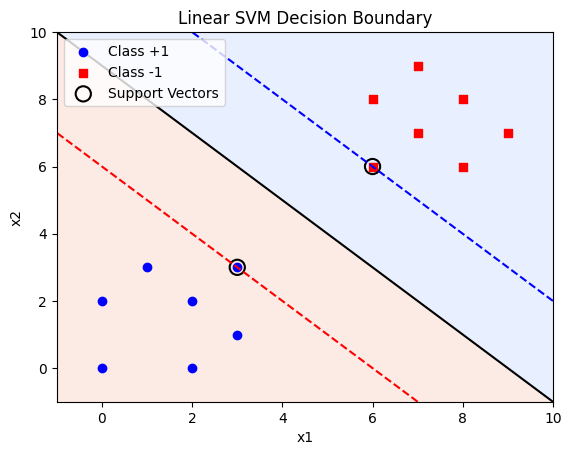

In [ ]:
plot_linear_svm(svm_hard, X, y)

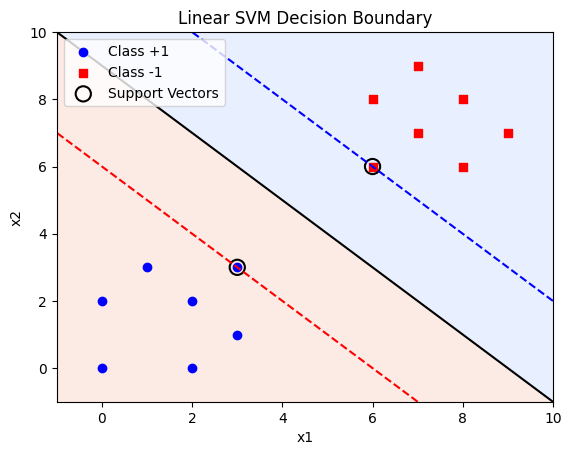

In [ ]:
plot_linear_svm(svm_soft, X, y)

In [ ]:
# Currently this gives an error as you will need to
# implement the return_support_vectors function which returns
# svm.support_vectors, svm.support_vector_labels, svm.support_vector_alphas.
plot_svm_decision_boundary(svm_soft, X, y)

TypeError: 'NoneType' object is not iterable